# **02 Model evolution along a *P*–*T*-path**
---

This notebook shows you how to:
1. Model the system evolution of a rock along a predefined *P*–*T*-trajectory, by:
    * Automatically calling repeated Theriak minimisations.
2. Visualisation of mineral modes (volume %) and $\Delta G$ as a function of *P* and *T*.
3. Start to adapt more complex modelling strategies including porphyroblast fractionation.\
    *simulating two different behaviors:*
    * Complete inertisation for garnet crystallisation.
    * Inherited resorption upon complete break-down for lawsonite.

The main aim of this notebook is to showcase how pytheriak can be used to implement increasingly complex petrogenetic models.

**Requirements:**
- python >= 3.10
*with the following packages installed:*
- pytheriak
- matplotlib
- seaborn
- pandas

*Theriak-Domino back-end:*
- A working Theriak-Domino installation.
- theriak.ini file in the working directory.
- Thermodynamic databases to use with Theriak in the working directory.
---

### Import all required libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pytheriak import wrapper

### Initiate a TherCaller-object.
The argument `programs_dir` must be set to the directory of your Theriak-Domino installation.\
The `database`-file (`"td-ds62-mb50-v07.txt"`) must be in your working directory, alongside this jupyter notebook. Get this database from [Databases](https://github.com/Theriak-Domino/Databases) on github.\
The Theriak-Domino database `"td-ds62-mb50-v07.txt"` is based on the Holland and Powell (2011, https://doi.org/10.1111/j.1525-1314.2010.00923.x) updated thermodynamic dataset file with accompanying solution models for metabasites.

In [2]:
theriak = wrapper.TherCaller(programs_dir="C:\\TheriakDominoWIN\\Programs",
                             database="td-ds62-mb50-v07.txt",
                             theriak_version="v2023.03.06")

### Set model parameter
*P*–*T*-path from Gerya et al. (2002) in Vho et al. Fig. 2 (2020, https://doi.org/10.5194/se-11-307-2020).\
The *P*–*T*-path was digitized using the ***Pathfinder***-module written by Thorsten Markmann (2023, unpubl.).\
\
Bulk rock compositions of metabasalt (MORB, AOC) in Vho et al. (2020, https://doi.org/10.5194/se-11-307-2020).\
An amount of excess oxygen `"O(0.2)"` is added given the presence of Fe(III) and Fe(II) in metabasalts.

In [3]:
pt_path = np.loadtxt(Path("PTpath_Gerya2002.txt")).T
bulk_MORB = "SI(44.78)TI(1.12)AL(15.37)FE(7.74)MN(0.00)MG(10.03)CA(10.83)NA(4.80)K(0.18)H(30.64)O(?)O(0.2)"
bulk_AOC = "SI(41.37)TI(0.76)AL(16.54)FE(4.76)MN(0.00)MG(8.97)CA(12.46)NA(3.61)K(0.64)H(35.28)O(?)O(0.2)"

# change this to see the effect of different bulk compositions
bulk_input = bulk_AOC

Create lists to store the data we want to track along the *P*–*T*-path.\
In this example we are interested in the modal abundance of lawsonite. Beyond the lawsonite stability field, we track the $\Delta G$ to equilibrium of lawsonite.

In [4]:
lawsonite_stable = []
lawsonite_vol_percent = []
lawsonite_dG = []
# to have complete data, store all rocks along PT path
rocks = []

Loop over temperature and pressure pairs in `pt_path`.\
For every *P*–*T*-point `theriak.minimisation()` is called. Lawsonite stability is checked by looking for `"law"` in `mineral_assemblage`.\
If lawsonite is stable we save the modal abundance of lawsonite in `lawsonite_vol_percent`. Otherwise we save the $\Delta G$ to equilibrium of lawsonite in `lawsonite_dG`.

This model setup assumes complete re-equilibration of the system at every *P*–*T*-point.

In [5]:
for temperature, pressure in pt_path:
    rock, element_list = theriak.minimisation(pressure, temperature, bulk_input, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names
    # when "law" is in the list of mineral names, it is stable
    lawsonite_stable.append(law_stable)

    # if lawsonite is stable, store its volume percent, delta G is None in that case
    if law_stable:
        law_idx = mineral_names.index("law")
        lawsonite_vol_percent.append(rock.mineral_assemblage[law_idx].vol_percent)
        lawsonite_dG.append(None)
    # if lawsonite is not stable, store its delta G, volume percent is None in that case
    else:
        lawsonite_vol_percent.append(None)
        lawsonite_dG.append(rock.mineral_delta_G["law"])

    rocks.append(rock)

Warnings, that water saturated conditions are not attained, might show up for the first *P*–*T*-points. In this cases liquid $\text{H}_{2}\text{O}$ is not a stable phase. The bulk is defined, so that saturation is given at 350 °C and 1.3 GPa (Vho et al., 2020).\
Note that these warnings can be turned off, by setting `wrapper.TherCaller(*args, verbose=False)`.

All the data lists, pressure, and temperature are combined into a `pd.DataFrame`.

In [6]:
laws_in_MORB = pd.DataFrame({"Temperature": pt_path[:, 0],
                             "Pressure": pt_path[:, 1],
                             "Pressure_kbar": pt_path[:, 1] / 1000,
                             "Lawsonite stable": lawsonite_stable,
                             "Lawsonite vol %": lawsonite_vol_percent,
                             "Lawsonite dG": lawsonite_dG})

A DataFrame allows data visualisation in a user-friendly spreadsheet-like style.
Look at the first and last entries with `head()` and `tails()`.

In [7]:
laws_in_MORB.head()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
0,350.000,12965.204236,12.965204,True,36.1209,NaN
1,373.625,14417.549168,14.417549,True,36.1945,NaN
2,398.125,15930.408472,15.930408,True,36.2691,NaN
3,420.000,16777.609682,16.777610,True,36.2341,NaN
4,439.250,17534.039334,17.534039,True,36.2043,NaN


In [8]:
laws_in_MORB.tail()

,Temperature,Pressure,Pressure_kbar,Lawsonite stable,Lawsonite vol %,Lawsonite dG
13,619.500,23464.447806,23.464448,False,NaN,442.027
14,640.500,24069.591528,24.069592,False,NaN,1187.440
15,662.375,24765.506808,24.765507,False,NaN,2053.170
16,681.625,25340.393343,25.340393,False,NaN,2869.810
17,700.000,25975.794251,25.975794,False,NaN,3541.480


### **Plotting I:** Modal abundance and $\Delta G$ to equilibrium of lawsonite in a *P*–*T*-diagram.

The `seaborn` library is used for plotting.

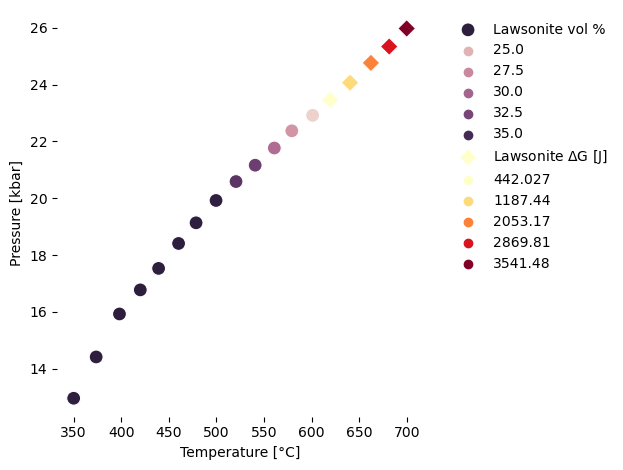

In [9]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                hue="Lawsonite vol %",
                s=100,
                label="Lawsonite vol %",
                ax=axs)

sns.scatterplot(data=laws_in_MORB,
                x="Temperature",
                y="Pressure_kbar",
                palette="YlOrRd",
                hue="Lawsonite dG",
                s=80,
                marker="D",
                label="Lawsonite $\Delta$G [J]",
                ax=axs)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Pressure [kbar]")

axs.legend(bbox_to_anchor=(1.05, 1), frameon=False)

axs.set_frame_on(False)

fig.tight_layout()

plt.show()

## **Updated modelling strategy: Porphyroblast fractionation**

Petrography of lawsonite-bearing blueschists and eclogites shows that lawsonite and garnet often form large porphyroblasts. Equilibration of such porphyroblasts with the matrix is inhibited, as indicated by major-element compositional zoning in these minerals. The elements bound in garnet and lawsonite are therefore effectively removed from the reactive bulk rock composition.\
To account for this in our model we must modify the above code. After each *P*–*T*-step the elements bound in garnet and lawsonite should be removed from the bulk to obtain a updated reactive bulk rock composition.\
We want to account for two different behaviors:
1. **Garnet** is assumed to be very robust against resorption and thus effectively inert. All crystallised garnet is non-reversibly removed from the reactive bulk rock composition.
2. **Lawsonite** resorption is assumed to be kinetically inhibited as long as lawsonite is stable in the rock. Upon complete breakdown of lawsonite, all elements bound in lawsonite are added back to the reactive bulk rock composition. This should mimic the observations of euhedral lawsonite porphyroblasts even in pseudomorphic replacements.

To model *Case 2: Lawsonite* at every *P*–*T*-step the stability of lawsonite is checked for a reactive bulk with fractionated and re-equilibrated lawsonite. If lawsonite is predicted stable in either of the two cases, it is treated as fractionated porphyroblast. Only if both cases predict lawsonite to be unstable, the elements bound in lawsonite are added back to the reactive bulk rock composition.

To simulate fractionation of the bulk composition the `input_bulk` (`str`) for `theriak.minimisation()` must be modified.\
For this purpose, a new function `bulk_from_compositionalvector()` is defined. This function can generate a `input_bulk`-string from a compositional vector (`Rock.bulk_composition_moles`) and the `element_list`.

For simulating the fractionation the compositional vector `Mineral.composition_moles` can be subtracted from compositional vector `Rock.bulk_composition_moles`.

In [10]:
def bulk_from_compositionalvector(composition: list | np.ndarray, element_list: list | np.ndarray):
    bulk = ""
    for moles, element in zip(composition, element_list):
        bulk += element
        bulk += "(" + str(moles) + ")"

    return bulk

Create lists to store the data we want to track along the *P*–*T*-path.\
An additonal list `lawsonite_restable_fract` is introduced to keep track of the scenario, where lawsonite is not-stable in the fractionated system, but would be re-stabilised in the refertilised system.

Since the total system volume is no longer equal to the reacting system volume an additional list `reactive_vol_fract` is defined. The latest reactive volume fraction from that list ($F_{reactive}$) is then used to approximate the modal abundance of lawsonite ($vol\%^{total}_{lws}$) and garnet ($vol\%^{total}_{grt}$) calculated at each *P*–*T*-step for the reactive bulk with respect to the total system:

$vol\%^{total}_i = vol\%^{reactive}_i \cdot F_{reactive}$

The reactive volume fraction is updated at each *P*–*T*-step: $F_{reactive,\ t+1} = F_{reactive,\ t} - \frac{vol\%^{total}_{lws}}{100} - \frac{vol\%^{total}_{grt}}{100}$.\
All these lists taking care of the systems volume are initialised with starting values for the first *P*–*T*-step.

For the fractionation of the bulk composition `np.ndarrays` tracking the compositional vectors in absolute moles for the reactive bulk rock (`reactive_bulk_moles`), lawsonite (`lawsonite_moles`), and garnet (`garnet_moles`) are defined.\
The reactive bulk rock composition ($\vec{C}_{bulk}$) is updated after each *P*–*T*-step by subtracting the compositional vector of the fractionated lawsonite ($\vec{C}_{lws}$) and garnet ($\vec{C}_{grt}$) from the reactive bulk rock composition:

($\vec{C}_{bulk,\ t+1} = \vec{C}_{bulk,\ t} - \vec{C}_{lws} - \vec{C}_{grt}$)

The reactive bulk rock composition is initialised with the MORB composition used in the previous model setup. While the compositional vectors for lawsonite and garnet are initialised with zeros.

In [11]:
lawsonite_stable_fract = []
lawsonite_restable_fract = []
garnet_stable_fract = []

lawsonite_dG_fract = []

rocks_fract = []

# lists to track reacting volume of system with fractionation
lawsonite_vol_percent_fract = [0]
garnet_vol_percent_fract = [0]
reactive_vol_fract = [1]

# these arrays take care of the absolute moles for fractionation calculations
# initialise with 0
lawsonite_moles = np.array([np.zeros(len(element_list))])
garnet_moles = np.array([np.zeros(len(element_list))])
# initialise with the bulk composition of MORB
reactive_bulk_moles = np.array([rocks[0].bulk_composition_moles])

Loop over temperature and pressure pairs in `pt_path`.\
For every *P*–*T*-point the following steps are performed:
1. New input bulk composition is generated using `bulk_from_compositionalvector()`.
2. `theriak.minimisation()` is called.
3. Stability of lawsonite is checked for the fractionated bulk rock composition.
4. If lawsonite is not stable in the fractionated bulk rock composition, the stability of lawsonite is checked for the refertilised bulk rock composition.
5. Garnet is fractionated if stable.
6. Depending if lawsonite is stable in either or none of the two cases, it is treated as a fractionated porphyroblast or added back to the reactive bulk rock composition.
7. Reactive volume fraction and reactive bulk rock composition are updated.

In [12]:
for temperature, pressure in pt_path:
    input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1], element_list)

    rock, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

    # look for lawsonite in the names of the mineral assemblage
    mineral_names = [mineral.name for mineral in rock.mineral_assemblage]
    law_stable = "law" in mineral_names

    if not law_stable:
        # change the input (reactive) bulk to include lawsonite
        input_bulk = bulk_from_compositionalvector(reactive_bulk_moles[-1] + lawsonite_moles[-1], element_list)
        rock_incl_law, element_list = theriak.minimisation(pressure, temperature, input_bulk, return_failed_minimisation=True)

        # look for lawsonite in the names of the mineral assemblage
        mineral_names_incl_law = [mineral.name for mineral in rock_incl_law.mineral_assemblage]
        law_restable = "law" in mineral_names_incl_law

        if law_restable:

            print(f"Lawsonite, got restabilised at {temperature:.0f} °C and {pressure:.0f} bar".format(temperature, pressure))

        else:
            rock = rock_incl_law
            mineral_names = mineral_names_incl_law
            reactive_bulk_moles[-1] += lawsonite_moles[-1]

        lawsonite_stable_fract.append(law_restable)

    else:
        lawsonite_stable_fract.append(law_stable)

    # look for garnet in the names of the mineral assemblage
    # all possible solutions (all starting with "GRT_") must be checked
    garnet_stable = len([mineral for mineral in mineral_names if mineral.startswith("GRT_")]) > 0
    # when "GRT_" is in the list of mineral names, it is stable
    garnet_stable_fract.append(garnet_stable)

    # append data of interest to lists
    if garnet_stable:
        garnet_idx = mineral_names.index([mineral for mineral in mineral_names if mineral.startswith("GRT_")][0])
        garnet_vol_percent = rock.mineral_assemblage[garnet_idx].vol_percent
        # correct for fraction of reacting volume
        garnet_vol_percent = garnet_vol_percent * reactive_vol_fract[-1]
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1] + garnet_vol_percent)

        # add the moles of garnet to the array
        new_garnet_moles = rock.mineral_assemblage[garnet_idx].composition_moles
        garnet_moles = np.append(garnet_moles, [new_garnet_moles], axis=0)

    else:
        garnet_vol_percent = 0
        garnet_vol_percent_fract.append(garnet_vol_percent_fract[-1])

        garnet_moles = np.append(garnet_moles, [np.zeros(len(element_list))], axis=0)


    if law_stable:
        law_idx = mineral_names.index("law")
        law_vol_percent = rock.mineral_assemblage[law_idx].vol_percent

        # correct for fraction of reacting volume
        law_vol_percent = law_vol_percent * reactive_vol_fract[-1]
        lawsonite_vol_percent_fract.append(lawsonite_vol_percent_fract[-1] + law_vol_percent)

        # add the moles of lawsonite to the array
        new_lawsonite_moles = rock.mineral_assemblage[law_idx].composition_moles

        lawsonite_moles = np.append(lawsonite_moles, [new_lawsonite_moles], axis=0)

        lawsonite_dG_fract.append(None)

    else:
        if law_restable:
            lawsonite_vol_percent_fract.append(lawsonite_vol_percent_fract[-1])
        else:
            lawsonite_vol_percent_fract.append(None)

        lawsonite_moles = np.append(lawsonite_moles, [np.zeros(len(element_list))], axis=0)

        lawsonite_dG_fract.append(rock.mineral_delta_G["law"])

    # update reactive volume
    reactive_vol_fract.append(reactive_vol_fract[-1] - law_vol_percent/100 - garnet_vol_percent/100)

    # fractionate the bulk composition
    reactive_bulk_moles = np.append(reactive_bulk_moles, [reactive_bulk_moles[-1] - lawsonite_moles[-1] - garnet_moles[-1]], axis=0)

Lawsonite, got restabilised at 420 °C and 16778 bar


By adding a print statement in the case of lawsonite only being stable in the refertilised bulk rock composition, we can track the occurrence of that phenomenon. The output of the above cell shows that this occurred once at 1.7 GPa and 420 °C.

Again, the data lists, pressure and temperature, are combined into a `pd.DataFrame`.\
For lists which have been initialised with a starting value (`lawsonite_vol_percent_fract`, `garnet_vol_percent_fract`), the first entry is removed by slicing `[1:]`.

In [13]:
laws_in_MORB_fract = pd.DataFrame({"Temperature": pt_path[:, 0],
                                   "Pressure": pt_path[:, 1],
                                   "Pressure_kbar": pt_path[:, 1] / 1000,
                                   "Lawsonite stable": lawsonite_stable_fract,
                                   "Lawsonite vol %": lawsonite_vol_percent_fract[1:],
                                   "Lawsonite dG": lawsonite_dG_fract,
                                   "Garnet stable": garnet_stable_fract,
                                   "Garnet vol %": garnet_vol_percent_fract[1:]})

### **Plotting II:** Modal abundance and $\Delta G$ to equilibrium of lawsonite in a *P*–*T*-diagram.

Analogous to above, below plots the results of our updated model using the `seaborn` library.

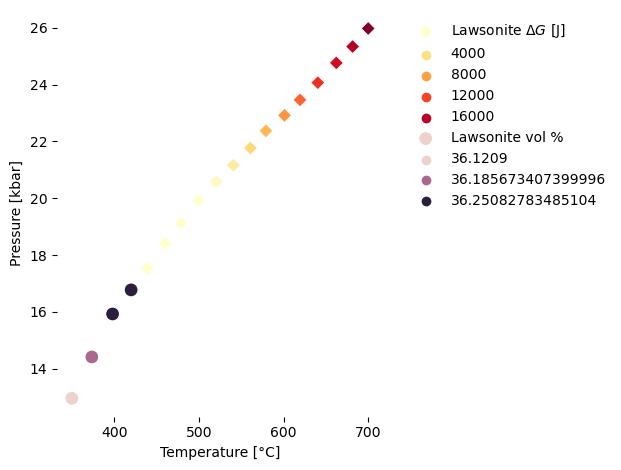

In [14]:
fig, axs = plt.subplots()

sns.scatterplot(data=laws_in_MORB_fract,
                x="Temperature",
                y="Pressure_kbar",
                palette="YlOrRd",
                hue="Lawsonite dG",
                s=50,
                marker="D",
                label=r"Lawsonite $\Delta G$ [J]",
                ax=axs)

sns.scatterplot(data=laws_in_MORB_fract,
                x="Temperature",
                y="Pressure_kbar",
                hue="Lawsonite vol %",
                s=100,
                label="Lawsonite vol %",
                ax=axs)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Pressure [kbar]")

axs.legend(bbox_to_anchor=(1.05, 1), frameon=False)

axs.set_frame_on(False)

fig.tight_layout()

plt.show()

### **Plotting III:** Mineral volume along P-T-path

In [15]:
COLOR_GARNET = "#900C3F"
COLOR_LAWSONITE = "#6c97d4"
COLOR_LAWSONITE_FRAC = "#2e0e8f"

Finally, we would like to compare our two modelling strategies.\
For this the modal abundance of lawsonite and $\Delta G$ after lawsonite breakdown are plotted along the increasing temperature on the *P*–*T*-path. For the fractionating model the modal abundance of garnet is also plotted.

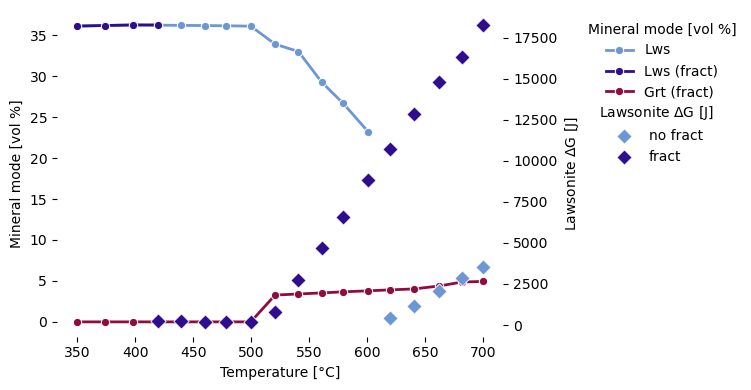

In [16]:
fig, axs = plt.subplots(figsize=(9, 4))

sns.lineplot(data=laws_in_MORB,
             x="Temperature",
             y="Lawsonite vol %",
             c=COLOR_LAWSONITE,
             lw=2,
             marker="o",
             label="Lws",)

sns.lineplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Lawsonite vol %",
             c=COLOR_LAWSONITE_FRAC,
             lw=2,
             marker="o",
             label="Lws (fract)")

sns.lineplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Garnet vol %",
             c=COLOR_GARNET,
             lw=2,
             marker="o",
             label="Grt (fract)")

axs2 = plt.twinx(axs)

sns.scatterplot(data=laws_in_MORB,
             x="Temperature",
             y="Lawsonite dG",
             c=COLOR_LAWSONITE,
             marker="D",
             s=60,
             label="no fract",
             ax=axs2)

sns.scatterplot(data=laws_in_MORB_fract,
             x="Temperature",
             y="Lawsonite dG",
             c=COLOR_LAWSONITE_FRAC,
             marker="D",
             s=60,
             label="fract",
             ax=axs2)

axs.set_xlabel("Temperature [°C]")
axs.set_ylabel("Mineral mode [vol %]")
axs2.set_ylabel(r"Lawsonite $\Delta$G [J]")

axs.legend(title="Mineral mode [vol %]", bbox_to_anchor=(1.55, 1), frameon=False)
axs2.legend(title=r"Lawsonite $\Delta$G [J]", bbox_to_anchor=(1.5, 0.75), frameon=False)

axs.set_frame_on(False)
axs2.set_frame_on(False)

fig.tight_layout()

plt.show()

Some interesting observations from this comparison:
* Lws breakdown occurs at a lower temperature (440 °C) in the model accounting for fractionation of the reactive bulk rock composition.
* In the model without any fractionation lawsonite is generally closer to equilibrium after breakdown (smaller $\Delta G$).

This notebook is a basic example on how pytheriak allows to expand a purely equilibrium thermodynamics approach (Theriak-Domino) to a more complex model incorporating some kinetic effects.\
It serves as a starting point for further development of more complex models. Other python codes modelling geodynamics, kinetics, or other processes deliver this complexity with pytheriak providing the link to Theriak-Domino's thermodynamic Gibbs Free Energy minimisation.